# Quantile regression

https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html

## Setup libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext watermark
%watermark -iv

matplotlib: 3.5.1
seaborn   : 0.11.2
numpy     : 1.22.1



In [3]:
pal = sns.color_palette()

## Generate data

In [4]:
rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x

Generate noise

In [5]:
normal_noise = rng.normal(loc=0, scale=0.5, size=x.shape[0])

In [6]:
heteroscedastic_noise = rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])

Text(0.5, 1.0, 'heteroscedastic')

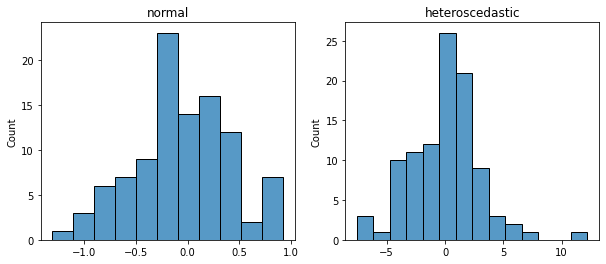

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.histplot(normal_noise, ax=ax[0])
sns.histplot(heteroscedastic_noise, ax=ax[1])
ax[0].set_title('normal')
ax[1].set_title('heteroscedastic')

Add heteroscedastic noise

In [8]:
y_normal = y_true_mean + heteroscedastic_noise

Text(0.5, 1.0, 'Distribution of residuals')

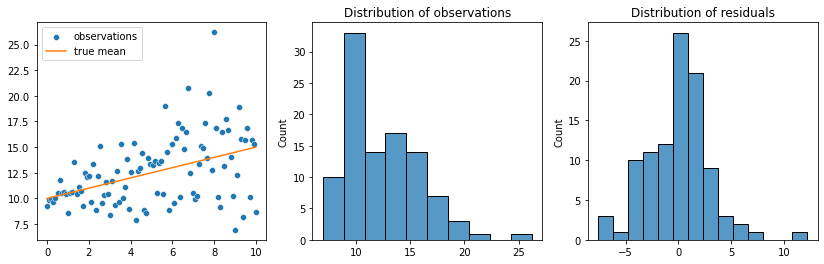

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
sns.scatterplot(x=x, y=y_normal, ax=ax[0], color=pal[0], label='observations')
sns.lineplot(x=x, y=y_true_mean, ax=ax[0], color=pal[1], label='true mean')
ax[0].legend()
sns.histplot(y_normal, ax=ax[1])
ax[1].set_title('Distribution of observations')
sns.histplot(y_normal - y_true_mean, ax=ax[2])
ax[2].set_title('Distribution of residuals')

In [10]:
a = 5
pareto_example = rng.pareto(a, size=x.shape[0])

<AxesSubplot:ylabel='Count'>

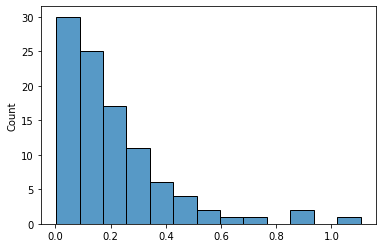

In [11]:
sns.histplot(pareto_example)

Generate dataset with asymmetric pareto distributed target

In [12]:
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

Text(0.5, 1.0, 'Distribution of residuals')

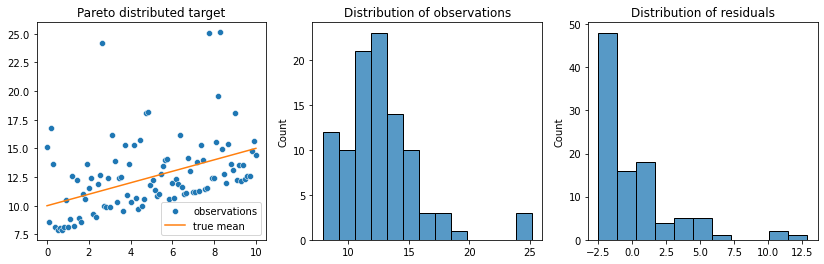

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
sns.scatterplot(x=x, y=y_pareto, ax=ax[0], color=pal[0], label='observations')
sns.lineplot(x=x, y=y_true_mean, ax=ax[0], color=pal[1], label='true mean')
ax[0].legend()
ax[0].set_title('Pareto distributed target')
sns.histplot(y_pareto, ax=ax[1])
ax[1].set_title('Distribution of observations')
sns.histplot(y_pareto - y_true_mean, ax=ax[2])
ax[2].set_title('Distribution of residuals')

With the heteroscedastic normal distributed target the variance of the noise incrases when the value of the feature x increases.
With the asymetric Pareto distributed target the negative residuals are bounded.
These noisy targets make the LinearRegression estimate less effient (need more data for stable results) and sensitive to outliers.

## QuantileRegressors

We estimate the conditional median as well as a low (5 percentile) and high (95 percentile) value for three linear models.

In [14]:
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression

In [15]:
def quantile_regressor_compute(X, y, quantiles):
    predictions = {}
    out_bounds_predictions = np.zeros_like(y, dtype=np.bool_)
    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantile, alpha=0)
        y_pred = qr.fit(X, y).predict(X)
        predictions[quantile] = y_pred

        if quantile == min(quantiles):
            out_bounds_predictions = np.logical_or(
                out_bounds_predictions, y_pred >= y
            )
        elif quantile == max(quantiles):
            out_bounds_predictions = np.logical_or(
                out_bounds_predictions, y_pred <= y
            )
    return predictions, out_bounds_predictions

In [16]:
def plot_reg_predictions(
    x, predictions, out_bounds_predictions, y_true_mean, y, title
):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        x, y_true_mean, color="black", linestyle="dashed", label="True mean"
    )
    for quantile, y_pred in predictions.items():
        ax.plot(x, y_pred, label=f"Quantile: {quantile}")
    ax.scatter(
        x[out_bounds_predictions],
        y[out_bounds_predictions],
        color="black",
        marker="+",
        alpha=0.5,
        label="Outside interval",
    )
    ax.scatter(
        x[~out_bounds_predictions],
        y[~out_bounds_predictions],
        color="black",
        alpha=0.5,
        label="Inside interval",
    )

    ax.legend()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    _ = ax.set_title(title)

In [17]:
y_pred_linear = LinearRegression().fit(X, y_normal).predict(X)

## Heteroscedastic normal distributed target

In [18]:
quantiles = [0.05, 0.5, 0.95]

In [19]:
predictions, out_bounds_predictions = quantile_regressor_compute(
    X, y_normal, quantiles
)

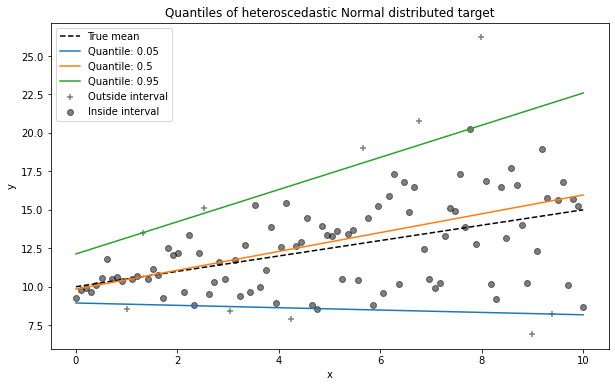

In [20]:
plot_reg_predictions(
    x,
    predictions,
    out_bounds_predictions,
    y_true_mean,
    y_normal,
    "Quantiles of heteroscedastic Normal distributed target",
)

## Asymmetric pareto distributed target

In [21]:
quantiles = [0.05, 0.5, 0.95]

In [22]:
predictions, out_bounds_predictions = quantile_regressor_compute(
    X, y_pareto, quantiles
)

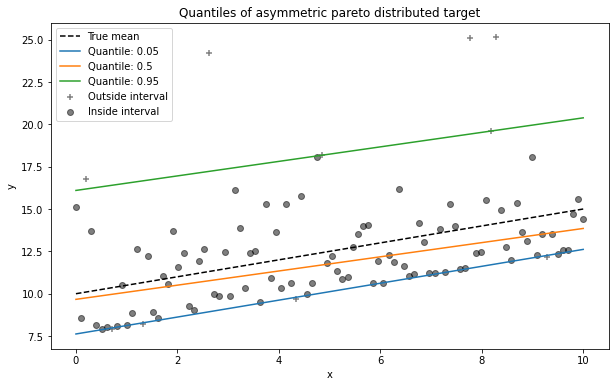

In [23]:
plot_reg_predictions(
    x,
    predictions,
    out_bounds_predictions,
    y_true_mean,
    y_pareto,
    "Quantiles of asymmetric pareto distributed target",
)

## Compare linear and quantile regression for Pareto distributed target

In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

linear_regression = LinearRegression()
quantile_regression = QuantileRegressor(quantile=0.5, alpha=0)

y_pred_lr = linear_regression.fit(X, y_pareto).predict(X)
y_pred_qr = quantile_regression.fit(X, y_pareto).predict(X)

In [27]:
def print_reg_metrics(y_actual, y_pred, title):
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    print(f'{title}: MAE = {mae:.3f} MSE = {mse:.3f}')

In [28]:
print_reg_metrics(
    y_pareto,
    y_pred_lr,
    'In-sample performance ' + linear_regression.__class__.__name__,
)

In-sample performance LinearRegression: MAE = 2.183 MSE = 9.015


In [29]:
print_reg_metrics(
    y_pareto,
    y_pred_qr,
    'In-sample performance ' + quantile_regression.__class__.__name__,
)

In-sample performance QuantileRegressor: MAE = 2.070 MSE = 9.792


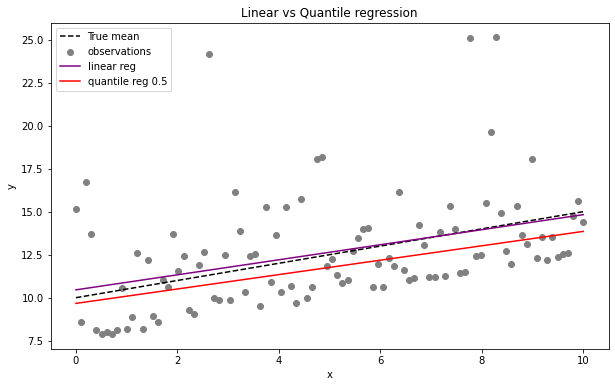

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y_true_mean, color="black", linestyle="dashed", label="True mean")
ax.scatter(x, y_pareto, color="gray", label="observations")
ax.plot(x, y_pred_lr, color="purple", label="linear reg")
ax.plot(x, y_pred_qr, color="red", label="quantile reg 0.5")
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
_ = ax.set_title('Linear vs Quantile regression')